
# <b></span><span style='color:#007bff'>Objectives : </span></b>

    
 1. Data Cleaning & Transformation: Remove duplicates, fill missing values, and fix outliers for clustering.
 2. Feature Engineering: Create new features from transaction data for better customer segmentation.
 3. Data Preprocessing: Scale features and reduce dimensions for efficient clustering.
 4. Customer Segmentation: Use K-means clustering to group customers for focused marketing.
 5. Cluster Analysis & Evaluation: Analyze customer groups to tailor marketing strategies and evaluate clustering.
6. Recommendation System: Suggest popular products to customers in the same group to boost sales.
 7. Gradio User Interface for the Recommendation System



# <b></span><span style='color:#007bff'>Importing Necessary Libraries </span></b>



In [1]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

<a id="load_dataset"></a>
# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Loading the Dataset</span></b>


In [4]:
df = pd.read_csv('transaction_data.csv',na_values=(" ","?","_","-1"), encoding="ISO-8859-1")

In [5]:
df.head(5)

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166.0,6355745,Sat Feb 02 12:50:00 IST 2019,465549.0,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701.0,6283376,Wed Dec 26 09:06:00 IST 2018,482370.0,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099.0,6385599,Fri Feb 15 09:45:00 IST 2019,490728.0,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478.0,6044973,Fri Jun 22 07:14:00 IST 2018,459186.0,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,NaN,6143225,Mon Sep 10 11:58:00 IST 2018,1733592.0,WASHROOM METAL SIGN,3,3.40,United Kingdom


In [6]:
# Dictionary mapping old column names to new column names
column_mappings = {
    'UserId': 'CustomerID',
    'TransactionId': 'InvoiceNo',
    'TransactionTime': 'InvoiceDate',
    'ItemCode': 'StockCode',
    'ItemDescription': 'Description',
    'NumberOfItemsPurchased': 'Quantity',
    'CostPerItem': 'UnitPrice',
    'Country': 'Country'  # This stays the same but is included for completeness
}

# Rename the columns
df = df.rename(columns=column_mappings)

# Now df has the columns renamed as specified
df = df.sort_values(by='InvoiceDate')



# <b></span><span style='color:#007bff'>Initial Data Analysis </span></b>




# <b></span><span style='color:#007bff'>Dataset Overview </span></b>



#### First I will perform a preliminary analysis to understand the structure and types of data columns:

In [7]:
df.head(10)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country
432402,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,1528779.0,PINK PILLAR CANDLE SILVER FLOCK,3,4.08,United Kingdom
446762,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,478086.0,PHOTO FRAME CORNICE,12,4.08,United Kingdom
464683,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,1528779.0,IVORY PILLAR CANDLE GOLD FLOCK,3,4.08,United Kingdom
400290,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,1732164.0,WOOD BLACK BOARD ANT WHITE FINISH,6,8.91,United Kingdom
837706,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,451185.0,RETROSPOT HEART HOT WATER BOTTLE,30,6.84,United Kingdom
402947,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,451185.0,RETROSPOT HEART HOT WATER BOTTLE,30,6.84,United Kingdom
881206,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,1732374.0,WOODEN FRAME ANTIQUE WHITE,18,4.08,United Kingdom
861201,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,1732206.0,WOOD S/3 CABINET ANT WHITE FINISH,12,10.98,United Kingdom
778432,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,447573.0,GLASS HEART T-LIGHT HOLDER,72,1.18,United Kingdom
70171,362103.0,5960185,Fri Apr 06 06:15:00 IST 2018,478086.0,PHOTO FRAME CORNICE,12,4.08,United Kingdom


In [8]:
number_of_projects = df['Country'].value_counts()
number_of_projects

United Kingdom          990956
Germany                  18990
France                   17114
EIRE                     16392
Spain                     5066
Netherlands               4742
Belgium                   4138
Switzerland               4004
Portugal                  3038
Australia                 2518
Norway                    2172
Italy                     1606
Channel Islands           1516
Finland                   1390
Cyprus                    1244
Sweden                     924
Unspecified                892
Austria                    802
Denmark                    778
Japan                      716
Poland                     682
Israel                     594
USA                        582
Hong Kong                  576
Singapore                  458
Iceland                    364
Canada                     302
Greece                     292
Malta                      254
United Arab Emirates       136
European Community         122
RSA                        116
Lebanon 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083818 entries, 432402 to 717499
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   CustomerID   813658 non-null   float64
 1   InvoiceNo    1083818 non-null  int64  
 2   InvoiceDate  1083818 non-null  object 
 3   StockCode    1078226 non-null  float64
 4   Description  1080816 non-null  object 
 5   Quantity     1083818 non-null  int64  
 6   UnitPrice    1083818 non-null  float64
 7   Country      1083818 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 74.4+ MB


<a id="statistics"></a>
# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Summary Statistics</span></b>


In [10]:
# Summary statistics for numerical variables
df['Description'].describe()

count                                1080816
unique                                  4222
top       WHITE HANGING HEART T-LIGHT HOLDER
freq                                    4738
Name: Description, dtype: object

In [11]:
# Summary statistics for categorical variables
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
CustomerID,813658.0,321042.0,35986.0,259266.0,293013.0,318192.0,352611.0,384027.0
InvoiceNo,1083818.0,6159417.0,147634.0,5900015.0,6026856.0,6166611.0,6289569.0,6397457.0
StockCode,1078226.0,661683.0,451308.0,42.0,461496.0,475419.0,488964.0,1894494.0
Quantity,1083818.0,29.0,654.0,-242985.0,3.0,9.0,30.0,242985.0
UnitPrice,1083818.0,9.0,2308.0,-15266.0,2.0,3.0,6.0,1696285.0


<Axes: >

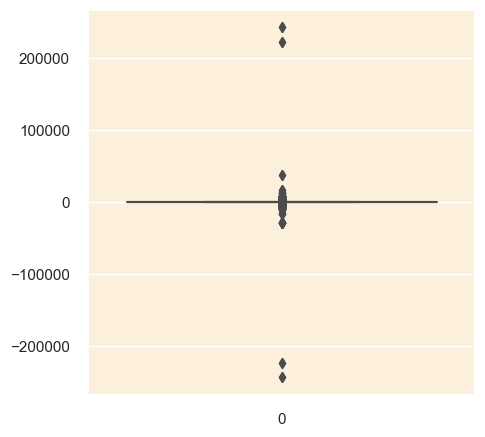

In [12]:

plt.figure(figsize=(5,5))
sns.boxplot(df['Quantity'])

# <b></span><span style='color:#007bff'>Data Cleaning & Transformation
</span></b>


# <b><span style='color:#007bff'> </span><span style='color:#007bff'> Handling Missing Values</span>

In [13]:
missing_data = df.isnull().sum()

In [14]:
missing_data.info()

<class 'pandas.core.series.Series'>
Index: 8 entries, CustomerID to Country
Series name: None
Non-Null Count  Dtype
--------------  -----
8 non-null      int64
dtypes: int64(1)
memory usage: 128.0+ bytes


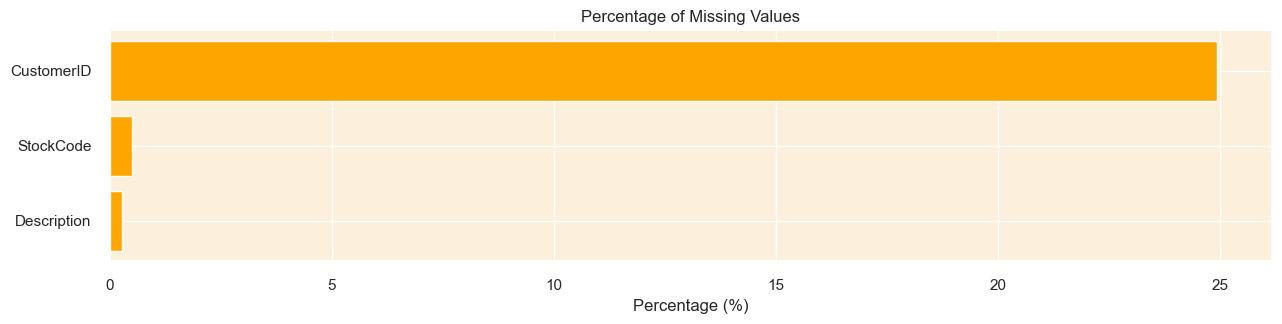

In [15]:
# Calculate the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Sort the missing percentages in ascending order
missing_percentage.sort_values(ascending=True, inplace=True)

# Create the bar chart
plt.figure(figsize=(15, 3))
plt.barh(missing_percentage.index, missing_percentage, color='orange')


# Add labels and titles for clarity
plt.title("Percentage of Missing Values")
plt.xlabel('Percentage (%)')

# Display the chart
plt.show()

In [16]:
missing_percentage

Description     0.276984
StockCode       0.515954
CustomerID     24.926694
dtype: float64

In [17]:
df['Description'].isnull().sum()

3002

In [18]:
df.sample(2)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country
994728,363615.0,6206101,Sun Nov 04 12:16:00 IST 2018,440916.0,JAZZ HEARTS ADDRESS BOOK,6,0.27,United Kingdom
555307,373590.0,5920134,Wed Feb 21 06:52:00 IST 2018,441714.0,REX CASH+CARRY JUMBO SHOPPER,3,1.32,United Kingdom


In [19]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df['CustomerID'].isnull() & df['Description'].isnull()].head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country
692100,NaN,5911950,Fri Feb 18 05:26:00 IST 2028,434364.0,NaN,-57,0.0,United Kingdom
1026399,NaN,5911939,Fri Feb 18 05:26:00 IST 2028,442134.0,NaN,-90,0.0,United Kingdom
96361,NaN,5911939,Fri Feb 18 05:26:00 IST 2028,442134.0,NaN,-90,0.0,United Kingdom
996014,NaN,5911950,Fri Feb 18 05:26:00 IST 2028,434364.0,NaN,-57,0.0,United Kingdom
478092,NaN,5911961,Fri Feb 18 05:27:00 IST 2028,1782501.0,NaN,-33,0.0,United Kingdom


In [20]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID'])

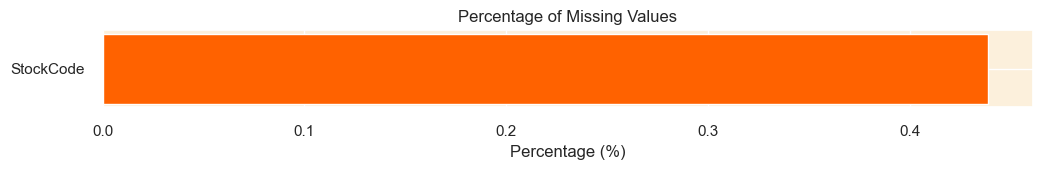

In [21]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)


# Create the bar chart
plt.figure(figsize=(12, 1))
plt.barh(missing_percentage.index, missing_percentage, color='#ff6200')


# Add labels and titles for clarity
plt.title("Percentage of Missing Values")
plt.xlabel('Percentage (%)')

# Display the chart
plt.show()


In [22]:

missing = df.isnull().sum()
missing

CustomerID        0
InvoiceNo         0
InvoiceDate       0
StockCode      3572
Description       0
Quantity          0
UnitPrice         0
Country           0
dtype: int64


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Handling Duplicates</span></b>

### Recognize duplicate rows in the dataset:

In [23]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country
1024276,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,456330.0,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
920591,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,456330.0,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
55169,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,477792.0,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
508218,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,477792.0,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
323263,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1492113.0,WHITE METAL LANTERN,18,4.68,United Kingdom
635173,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1492113.0,WHITE METAL LANTERN,18,4.68,United Kingdom
528742,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1764609.0,KNITTED UNION FLAG HOT WATER BOTTLE,18,4.68,United Kingdom
538323,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1764609.0,KNITTED UNION FLAG HOT WATER BOTTLE,18,4.68,United Kingdom
918916,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1764609.0,RED WOOLLY HOTTIE WHITE HEART.,18,4.68,United Kingdom
412255,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1764609.0,RED WOOLLY HOTTIE WHITE HEART.,18,4.68,United Kingdom


In [24]:
duplicate_rows_sorted.head(6)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country
1024276,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,456330.0,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
920591,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,456330.0,GLASS STAR FROSTED T-LIGHT HOLDER,18,5.87,United Kingdom
55169,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,477792.0,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
508218,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,477792.0,SET 7 BABUSHKA NESTING BOXES,6,10.56,United Kingdom
323263,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1492113.0,WHITE METAL LANTERN,18,4.68,United Kingdom
635173,374850.0,5900015,Mon Feb 12 04:26:00 IST 2018,1492113.0,WHITE METAL LANTERN,18,4.68,United Kingdom


<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">

<h3 align="left"><font color=#007bff>Handling Duplicates Strategy:</font></h3>
    
remove completely identical rows from the dataset to eliminate potential data recording errors, thereby enhancing the accuracy of customer clustering and improving the recommendation system by focusing on * unique transactions.

In [25]:

# Removing duplicate rows
df.drop_duplicates(inplace=True)

In [26]:
# Getting the number of rows in the dataframe
df.shape[0]

401569


# <b></span><span style='color:#007bff'> Treating Cancelled Transactions</span></b>

In [27]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = df['Quantity'] < 0
df['Transaction_Status'] = df['Transaction_Status'].astype(int)
# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 1]
cancelled_transactions.describe().drop('CustomerID', axis=1).round()

,InvoiceNo,StockCode,Quantity,UnitPrice,Transaction_Status
count,8871.0,8506.0,8871.0,8871.0,8871.0
mean,6149158.0,653160.0,-92.0,26.0,1.0
std,142615.0,438193.0,3517.0,614.0,0.0
min,5900169.0,42.0,-242985.0,0.0,1.0
25%,6022484.0,465533.0,-18.0,2.0,1.0
50%,6156370.0,477120.0,-6.0,4.0,1.0
75%,6269945.0,487389.0,-3.0,7.0,1.0
max,6397259.0,1894431.0,-3.0,53779.0,1.0


In [28]:
df.sample(10)


,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country,Transaction_Status
48317,358029.0,6391374,Mon Feb 18 06:48:00 IST 2019,477246.0,ALARM CLOCK BAKELIKE GREEN,12,5.18,United Kingdom,0
343596,328062.0,6065554,Tue Jul 10 09:35:00 IST 2018,470106.0,JUMBO BAG PINK POLKADOT,30,2.88,United Kingdom,0
207881,296016.0,6371156,Sat Feb 09 11:54:00 IST 2019,474054.0,HEART WOODEN CHRISTMAS DECORATION,24,2.25,United Kingdom,0
161461,329259.0,6119102,Wed Aug 22 04:24:00 IST 2018,1516872.0,FENG SHUI PILLAR CANDLE,144,0.27,United Kingdom,0
619405,275037.0,6248649,Wed Dec 05 08:58:00 IST 2018,481425.0,BLUE GIANT GARDEN THERMOMETER,6,8.22,United Kingdom,0
102393,271236.0,5960218,Fri Apr 06 06:43:00 IST 2018,1783866.0,ANTIQUE SILVER TEA GLASS ETCHED,18,1.73,United Kingdom,0
63757,337764.0,5982020,Fri Apr 27 12:05:00 IST 2018,1773639.0,YELLOW METAL CHICKEN HEART,36,2.06,United Kingdom,0
503375,379113.0,6259154,Wed Dec 12 05:05:00 IST 2018,474117.0,WOODEN HEART CHRISTMAS SCANDINAVIAN,78,0.41,United Kingdom,0
1044369,352674.0,6295311,Fri Jan 04 10:41:00 IST 2019,477120.0,SET OF 3 CAKE TINS PANTRY DESIGN,3,6.84,United Kingdom,0
607654,329427.0,6111457,Sat Aug 18 05:13:00 IST 2018,486465.0,LARGE CERAMIC TOP STORAGE JAR,36,2.28,United Kingdom,0


In [29]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

cancelled_percentage

2.209084864618534

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Correcting StockCode Anomalies</span></b>


<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">

converts two columns in the DataFrame to the data type 'object'

In [30]:
df['InvoiceNo'] = df['InvoiceNo'].astype('object')
df['StockCode'] = df['StockCode'].astype('object')

In [31]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

unique_stock_codes

3209

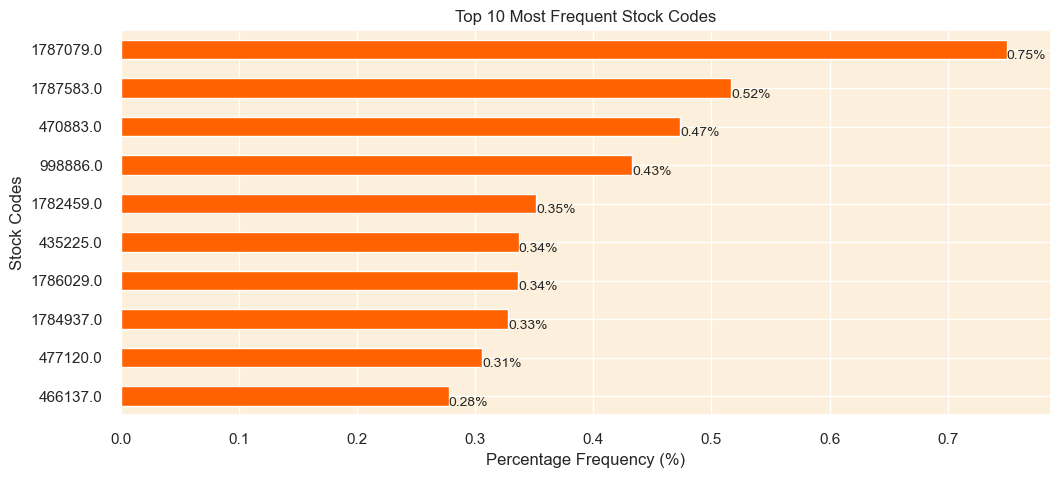

In [32]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [33]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

numeric_char_counts_in_unique_codes




7    2530
8     678
0       1
3       1
dtype: int64

In [34]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (1, 3)]

anomalous_stock_codes

[42.0]

In [35]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.03%


In [36]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [37]:
# Getting the number of rows in the dataframe
df.shape[0]

401435

<a id="Description_cleaning"></a>
# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Cleaning Description Column</span></b>

In [38]:
# Calculate the occurrence of each unique description and sort them

description_counts = df['Description'].value_counts()
description_counts

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
                                      ... 
72 CAKE CASES VINTAGE CHRISTMAS          1
WRAP BLUE RUSSIAN FOLKART                1
DUSTY PINK CHRISTMAS TREE 30CM           1
BLACKCHRISTMAS TREE 30CM                 1
PINK EASTER HENS+FLOWER                  1
Name: Description, Length: 3895, dtype: int64

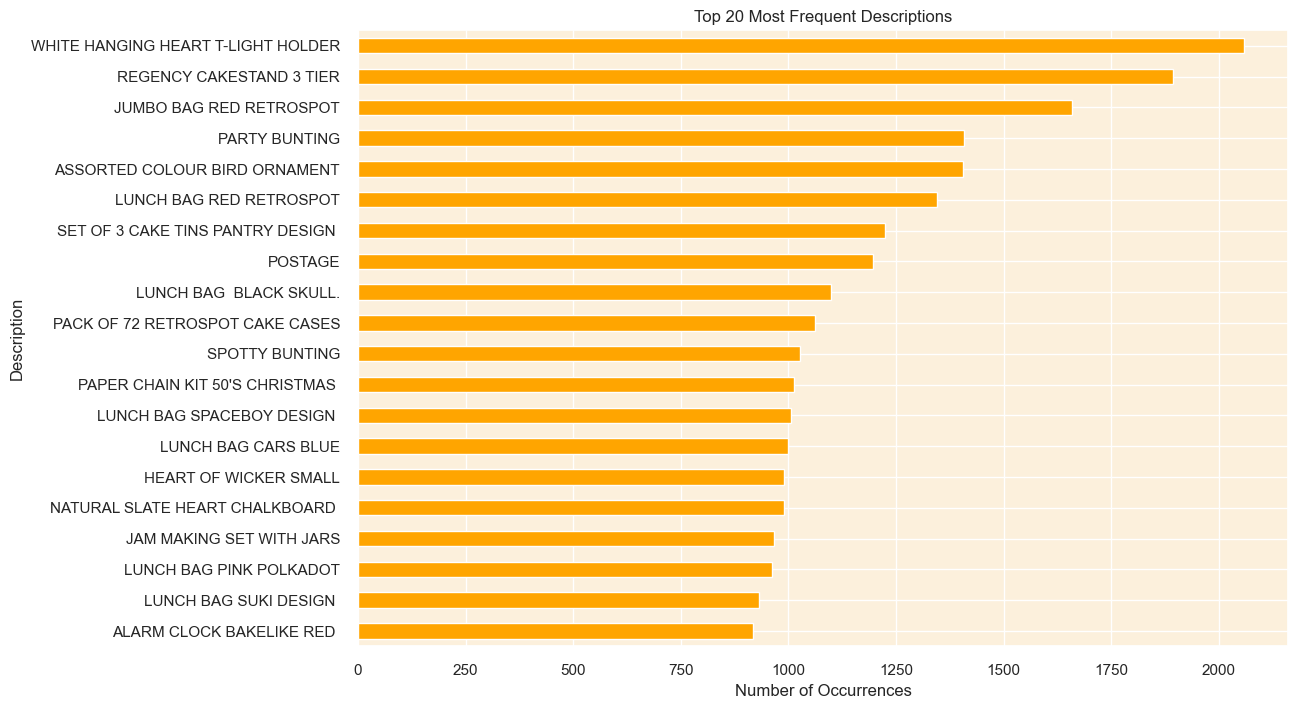

In [39]:
top_20_descriptions = df['Description'].value_counts().head(20)

# Plotting the top 20 descriptions as a horizontal bar chart
plt.figure(figsize=(12, 8))
top_20_descriptions.plot(kind='barh', color='orange')

# Adding labels and a title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 20 Most Frequent Descriptions')

# Reversing the y-axis to display the highest values at the top
plt.gca().invert_yaxis()

# Displaying the plot
plt.show()

In [40]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
3 TRADITIONAl BISCUIT CUTTERS  SET
FLOWERS HANDBAG blue and orange
Manual
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FOLK ART GREETING CARD,pack/12
THE KING GIFT BAG 25x24x12cm
FRENCH BLUE METAL DOOR SIGN No
Next Day Carriage
BAG 500g SWIRLY MARBLES
Discount
NUMBER TILE COTTAGE GARDEN No
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 65CMx65CM
CRUK Commission
High Resolution Image
Bank Charges
POLYESTER FILLER PAD 60x40cm


In [41]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [42]:
# Getting the number of rows in the dataframe
df.shape[0]

401352

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Treating Zero Unit Prices</span></b>


In [43]:
df['UnitPrice'].describe()

count    4.013520e+05
mean     9.001558e+00
std      2.679265e+03
min      0.000000e+00
25%      1.730000e+00
50%      2.700000e+00
75%      5.180000e+00
max      1.696285e+06
Name: UnitPrice, dtype: float64

In [44]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,40.00000
mean,1041.30000
std,5934.93544
min,3.00000
25%,3.00000
50%,13.50000
75%,72.00000
max,37620.00000


In [45]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Outlier Treatment</span></b>


In [46]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [47]:
# Getting the number of rows in the dataframe
df.shape[0]

401312

In [48]:
df.sample(5)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country,Transaction_Status
188870,318024.0,6171957,Sat Oct 06 05:48:00 IST 2018,482160.0,JAM MAKING SET WITH JARS,18,5.87,United Kingdom,0
180400,274869.0,5955510,Sat Mar 31 12:06:00 IST 2018,463827.0,PAPER BUNTING WHITE LACE,18,4.08,United Kingdom,0
29029,369789.0,6306795,Fri Jan 11 08:14:00 IST 2019,489762.0,LARGE WHITE HEART OF WICKER,6,4.08,United Kingdom,0
131653,354879.0,6158691,Mon Sep 24 07:33:00 IST 2018,477267.0,ALARM CLOCK BAKELIKE RED,9,5.18,United Kingdom,0
159303,361011.0,5911400,Sat Feb 17 10:36:00 IST 2018,477897.0,LARGE RED BABUSHKA NOTEBOOK,6,1.73,United Kingdom,0


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Filter year > 2019</span></b>


In [49]:
df['InvoiceDate'].max()

'Wed Sep 26 13:29:00 IST 2018'

In [50]:
df['InvoiceDate'].min()

'Fri Apr 06 06:15:00 IST 2018'

In [51]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
max_year = df['InvoiceDate'].dt.year.max()
max_year
df = df[df['InvoiceDate'].dt.year != max_year]
df['InvoiceDate'].dt.year.max()

2019

# Feature Engineering 

 # RFM Features

## <b><span style='color:#fcc36d'></span><span style='color:#ff6200'> Recency (R)</span></b>


In [52]:


# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
# Remove all rows where 'InvoiceDay' is equal to the maximum value of 'InvoiceDay'


# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [53]:
df.head(2)

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Country,Transaction_Status,InvoiceDay
0,362103.0,5960185,2018-04-06 06:15:00,1528779.0,PINK PILLAR CANDLE SILVER FLOCK,3,4.08,United Kingdom,0,2018-04-06
1,362103.0,5960185,2018-04-06 06:15:00,478086.0,PHOTO FRAME CORNICE,12,4.08,United Kingdom,0,2018-04-06


In [54]:
df['InvoiceDay'].max()

datetime.date(2019, 2, 20)

In [55]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,259266.0,325
1,259287.0,2
2,259308.0,75
3,259329.0,18
4,259350.0,310


## <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Frequency (F)</span></b>


In [56]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,259266.0,325,2,0
1,259287.0,2,6,6417
2,259308.0,75,4,7023
3,259329.0,18,1,1893
4,259350.0,310,1,591


## <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Monetary (M)</span></b>


In [57]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,259266.0,325,2,0,0.00,0.00
1,259287.0,2,6,6417,14928.18,2488.03
2,259308.0,75,4,7023,7481.52,1870.38
3,259329.0,18,1,1893,7285.92,7285.92
4,259350.0,310,1,591,1387.20,1387.20


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Product Diversity</span></b>


In [58]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,259266.0,325,2,0,0.00,0.00,1
1,259287.0,2,6,6417,14928.18,2488.03,85
2,259308.0,75,4,7023,7481.52,1870.38,21
3,259329.0,18,1,1893,7285.92,7285.92,71
4,259350.0,310,1,591,1387.20,1387.20,16


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Behavioral Features</span></b>


In [59]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.sort_values().diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,259266.0,325,2,0,0.00,0.00,1,0.000000,6,6
1,259287.0,2,6,6417,14928.18,2488.03,85,2.100000,5,8
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15
3,259329.0,18,1,1893,7285.92,7285.92,71,0.000000,5,5
4,259350.0,310,1,591,1387.20,1387.20,16,0.000000,0,12


# <b><span style='color:#fcc36d'></span><span style='color:007bff'> Geographic Features</span></b>


In [60]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.888444
Germany           0.023638
France            0.021017
EIRE              0.018426
Spain             0.006314
Name: Country, dtype: float64

<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">
<h3 align="left"><font color=#007bff>Inference: </font></h3>
    
 a substantial portion (__89%__) of transactions are originating from the __United Kingdom__, we might consider creating a binary feature indicating whether the transaction is from the UK or not. 

In [61]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,259266.0,325,2,0,0.00,0.00,1,0.000000,6,6,1
1,259287.0,2,6,6417,14928.18,2488.03,85,2.100000,5,8,0
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0
3,259329.0,18,1,1893,7285.92,7285.92,71,0.000000,5,5,0
4,259350.0,310,1,591,1387.20,1387.20,16,0.000000,0,12,0


In [62]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

1    3864
0     419
Name: Is_UK, dtype: int64

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Cancellation Insights</span></b>


<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">

Cancellation Frequency: This feature counts the total number of transactions a customer has canceled. High cancellation frequency might indicate dissatisfaction or other issues, helping us identify and address the causes to improve customer satisfaction.
    
Cancellation Rate: This is the percentage of a customer’s transactions that were canceled, providing a normalized view of their cancellation behavior. A high cancellation rate could suggest an unsatisfied customer segment, allowing us to target strategies specifically to improve their experience and reduce cancellations.

In [63]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 1]
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,259266.0,325,2,0,0.00,0.00,1,0.000000,6,6,1,1.0,0.5
1,259287.0,2,6,6417,14928.18,2488.03,85,2.100000,5,8,0,0.0,0.0
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0,0.0,0.0
3,259329.0,18,1,1893,7285.92,7285.92,71,0.000000,5,5,0,0.0,0.0
4,259350.0,310,1,591,1387.20,1387.20,16,0.000000,0,12,0,0.0,0.0


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Seasonality & Trends</span></b>


In [64]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,259266.0,325,2,0,0.00,0.00,1,0.000000,6,6,1,1.0,0.5,0.00,0.000000,0.000000
1,259287.0,2,6,6417,14928.18,2488.03,85,2.100000,5,8,0,0.0,0.0,2488.03,1537.619795,109.482857
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0,0.0,0.0,1870.38,1249.579637,-671.256000
3,259329.0,18,1,1893,7285.92,7285.92,71,0.000000,5,5,0,0.0,0.0,7285.92,0.000000,0.000000
4,259350.0,310,1,591,1387.20,1387.20,16,0.000000,0,12,0,0.0,0.0,1387.20,0.000000,0.000000


In [65]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [66]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,259266.0,325,2,0,0.0,0.0,1,0.0,6,6,1,1,0.5,0.0,0.0,0.0
1,259287.0,2,6,6417,14928.18,2488.03,85,2.1,5,8,0,0,0.0,2488.03,1537.619795,109.482857
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0,0,0.0,1870.38,1249.579637,-671.256
3,259329.0,18,1,1893,7285.92,7285.92,71,0.0,5,5,0,0,0.0,7285.92,0.0,0.0
4,259350.0,310,1,591,1387.2,1387.2,16,0.0,0,12,0,0,0.0,1387.2,0.0,0.0
5,259392.0,36,11,1410,6406.32,582.392727,57,2.765957,6,10,0,3,0.272727,1281.264,877.069839,165.024
6,259413.0,204,1,60,369.0,369.0,4,0.0,1,13,0,0,0.0,369.0,0.0,0.0
7,259434.0,232,1,1590,4479.54,4479.54,58,0.0,1,9,0,0,0.0,4479.54,0.0,0.0
8,259455.0,214,1,720,1905.78,1905.78,11,0.0,5,9,0,0,0.0,1905.78,0.0,0.0
9,259476.0,22,3,4773,11659.47,3886.49,52,5.224138,6,5,0,0,0.0,3886.49,4871.115422,-4588.62


In [105]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4283 entries, 0 to 4282
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4283 non-null   string 
 1   Days_Since_Last_Purchase        4283 non-null   Int64  
 2   Total_Transactions              4283 non-null   Int64  
 3   Total_Products_Purchased        4283 non-null   Int64  
 4   Total_Spend                     4283 non-null   Float64
 5   Average_Transaction_Value       4283 non-null   Float64
 6   Unique_Products_Purchased       4283 non-null   Int64  
 7   Average_Days_Between_Purchases  4283 non-null   Float64
 8   Day_Of_Week                     4283 non-null   Int64  
 9   Hour                            4283 non-null   Int64  
 10  Is_UK                           4283 non-null   Int64  
 11  Cancellation_Frequency          4283 non-null   Int64  
 12  Cancellation_Rate               42

#  Outlier Detection and Treatment


In [68]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,259266.0,325,2,0,0.0,0.0,1,0.0,6,6,1,1,0.5,0.0,0.0,0.0,1,0
1,259287.0,2,6,6417,14928.18,2488.03,85,2.1,5,8,0,0,0.0,2488.03,1537.619795,109.482857,1,0
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0,0,0.0,1870.38,1249.579637,-671.256,1,0
3,259329.0,18,1,1893,7285.92,7285.92,71,0.0,5,5,0,0,0.0,7285.92,0.0,0.0,-1,1
4,259350.0,310,1,591,1387.2,1387.2,16,0.0,0,12,0,0,0.0,1387.2,0.0,0.0,1,0


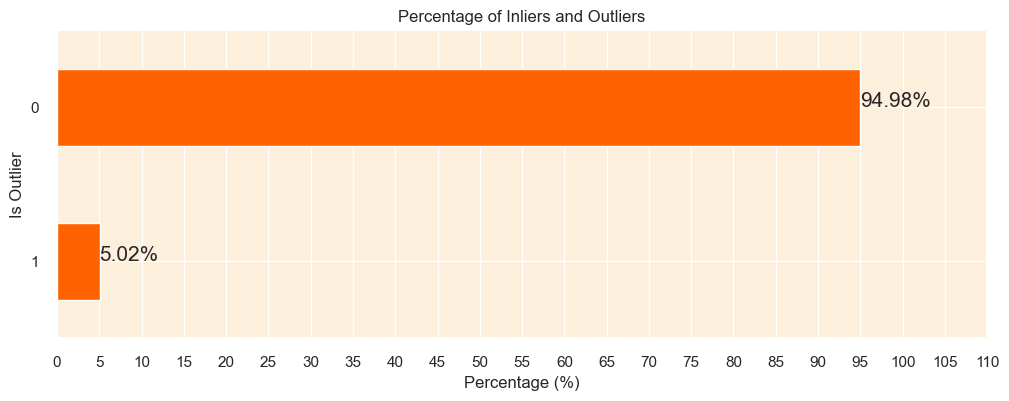

In [69]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [70]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [71]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4068

# Correlation Analysis


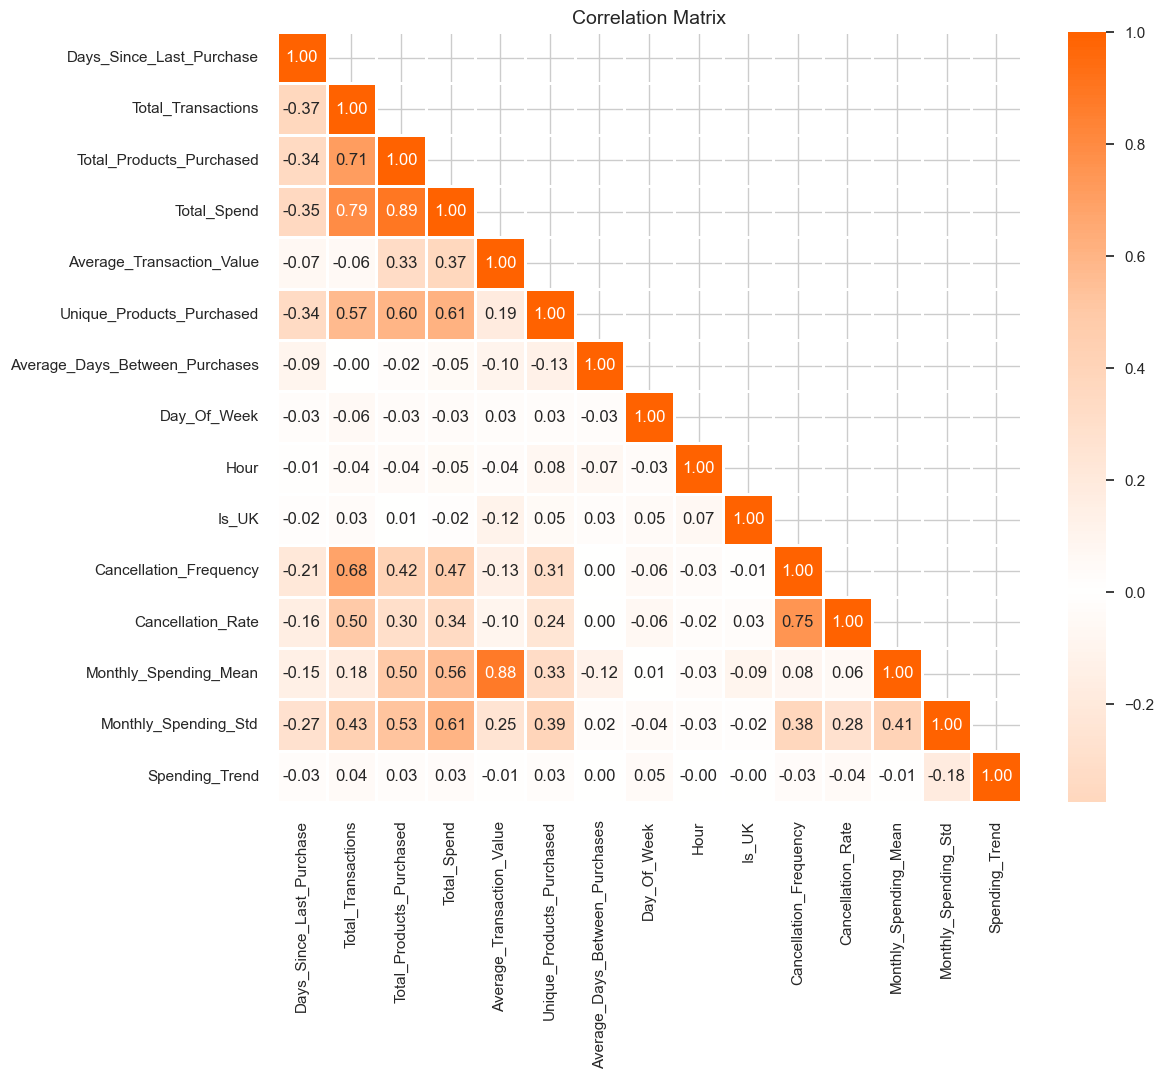

In [72]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">
<h3 align="left"><font color=#ff6200>Inference: </font></h3>


- `Monthly_Spending_Mean` and `Average_Transaction_Value`
    
    
- `Total_Spend` and `Total_Products_Purchased`

    
- `Total_Transactions` and `Total_Spend`
    
    
- `Cancellation_Rate` and `Cancellation_Frequency`
    
    
- `Total_Transactions` and `Total_Products_Purchased`
 


# Feature Scaling

In [73]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,259266.0,2.362745,-0.488018,-0.795729,-0.841981,-1.335893,-0.902840,-0.299327,6,-1.087256,1,0.339272,0.294856,-1.356196,-0.717421,0.078260
1,259287.0,-0.905156,0.451971,1.781428,1.909040,1.498106,0.535897,-0.118170,5,-0.220604,0,-0.539810,-0.412573,0.954852,1.412445,0.225230
2,259308.0,-0.166590,-0.018023,2.024806,0.536742,0.794570,-0.560284,0.514443,1,2.812676,0,-0.539810,-0.412573,0.381137,1.013460,-0.822839
3,259350.0,2.210985,-0.723015,-0.558375,-0.586342,0.244202,-0.645923,-0.299327,0,1.512699,0,-0.539810,-0.412573,-0.067673,-0.717421,0.078260
4,259392.0,-0.561167,1.626957,-0.229453,0.338600,-0.672516,0.056318,-0.060721,6,0.646047,0,2.097436,-0.026702,-0.166073,0.497470,0.299789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,383880.0,1.877113,-0.723015,-0.741511,-0.704017,-0.483141,-0.748690,-0.299327,5,-1.520581,1,-0.539810,-0.412573,-0.660800,-0.717421,0.078260
4064,383901.0,0.895731,-0.723015,-0.730667,-0.780283,-0.954538,-0.800073,-0.299327,4,-1.087256,1,-0.539810,-0.412573,-1.045212,-0.717421,0.078260
4065,383922.0,-0.854570,-0.253021,-0.677654,-0.706892,-1.057565,-0.714434,0.556138,2,0.212722,1,0.339272,-0.058858,-1.015744,-0.631297,-0.039778
4066,383943.0,-0.895039,2.801943,0.839242,0.722638,-0.731463,3.499012,-0.259310,1,0.646047,1,-0.539810,-0.412573,-0.479938,0.462305,0.370515


In [115]:
new_df= df.drop(columns=['InvoiceDate','InvoiceDay'])
new_df.to_csv('new_df_recomen.csv', index=False)


# Dimensionality Reduction


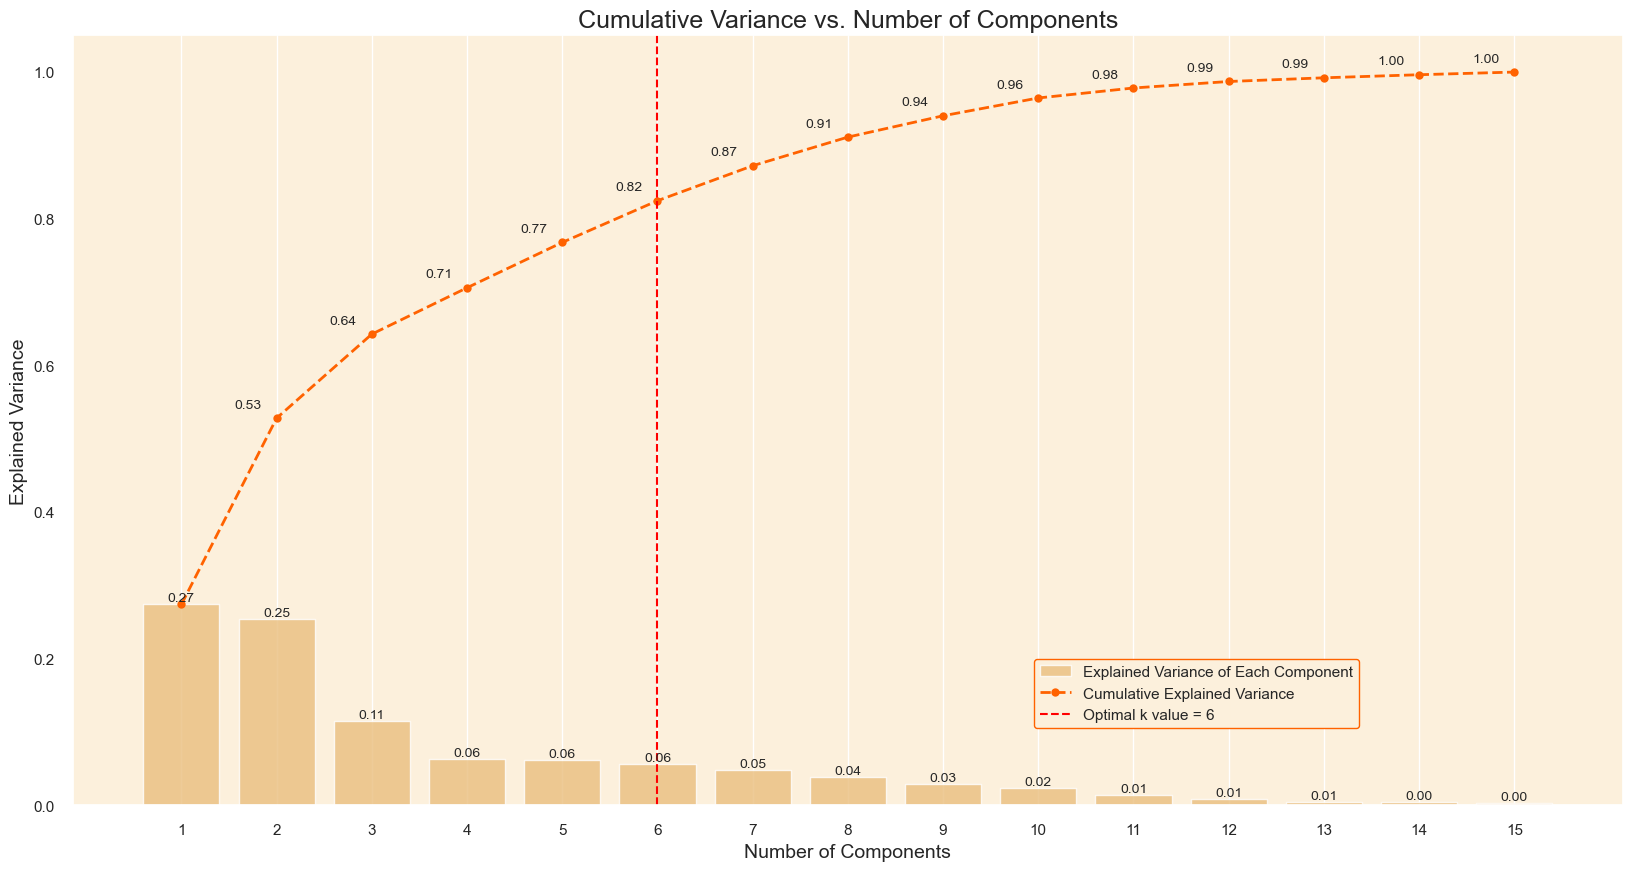

In [75]:
# Setting CustomerID as the index cءolumn
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [76]:
customer_data_scaled

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
CustomerID,,,,,,,,,,,,,,,
259266.0,2.362745,-0.488018,-0.795729,-0.841981,-1.335893,-0.902840,-0.299327,6,-1.087256,1,0.339272,0.294856,-1.356196,-0.717421,0.078260
259287.0,-0.905156,0.451971,1.781428,1.909040,1.498106,0.535897,-0.118170,5,-0.220604,0,-0.539810,-0.412573,0.954852,1.412445,0.225230
259308.0,-0.166590,-0.018023,2.024806,0.536742,0.794570,-0.560284,0.514443,1,2.812676,0,-0.539810,-0.412573,0.381137,1.013460,-0.822839
259350.0,2.210985,-0.723015,-0.558375,-0.586342,0.244202,-0.645923,-0.299327,0,1.512699,0,-0.539810,-0.412573,-0.067673,-0.717421,0.078260
259392.0,-0.561167,1.626957,-0.229453,0.338600,-0.672516,0.056318,-0.060721,6,0.646047,0,2.097436,-0.026702,-0.166073,0.497470,0.299789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383880.0,1.877113,-0.723015,-0.741511,-0.704017,-0.483141,-0.748690,-0.299327,5,-1.520581,1,-0.539810,-0.412573,-0.660800,-0.717421,0.078260
383901.0,0.895731,-0.723015,-0.730667,-0.780283,-0.954538,-0.800073,-0.299327,4,-1.087256,1,-0.539810,-0.412573,-1.045212,-0.717421,0.078260
383922.0,-0.854570,-0.253021,-0.677654,-0.706892,-1.057565,-0.714434,0.556138,2,0.212722,1,0.339272,-0.058858,-1.015744,-0.631297,-0.039778


In [77]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [78]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
259266.0,-3.864546,-0.193154,-1.765727,0.929485,-0.686588,-1.730735
259287.0,-0.437471,3.641349,1.801879,-0.152247,0.697670,0.324139
259308.0,2.110671,-0.032371,1.312493,-0.401400,-0.680176,2.452873
259350.0,1.241474,-3.138318,0.895609,-0.427072,-1.438324,-0.156785
259392.0,-1.822886,2.914064,-1.889035,-0.291597,-0.357183,0.196430


In [79]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.100446,-0.192336,0.065658,0.186245,-0.343459,-0.382686
Total_Transactions,0.228539,0.308548,-0.260390,-0.114353,0.036485,-0.035045
Total_Products_Purchased,0.224104,0.339056,0.069147,-0.093488,0.084675,0.003629
Total_Spend,0.237471,0.359655,0.071537,-0.060056,0.059375,-0.026982
Average_Transaction_Value,0.065295,0.156286,0.591397,0.115180,-0.008158,-0.099108
Unique_Products_Purchased,0.156412,0.291306,0.014716,-0.283199,-0.077216,0.135641
Average_Days_Between_Purchases,0.000209,-0.031400,-0.125975,0.242275,0.701778,0.317881
Day_Of_Week,-0.830696,0.550465,-0.060799,0.034354,-0.019840,0.010150
Hour,0.004949,-0.024399,-0.001497,-0.419599,-0.442645,0.592659
Is_UK,-0.005008,0.002275,-0.020851,-0.015857,-0.001923,0.023803


# K-Means Clustering

<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">

<h2 align="left"><font color=#007bff>K-Means:</font></h2>

- __K-Means__ is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the __within-cluster sum-of-squares (WCSS)__, also known as __inertia__. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached. 


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Determining the Optimal Number of Clusters</span></b>


<div style=padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">



Elbow Method__

Silhouette Method

    


<a id="elbow"></a>
## <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Elbow Method</span></b>


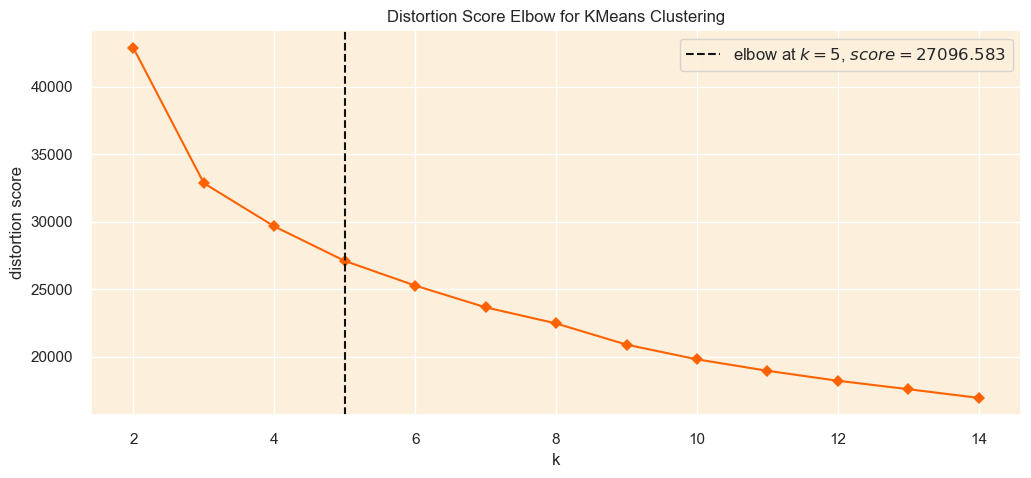

In [80]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();


## <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Silhouette Method</span></b>


In [81]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

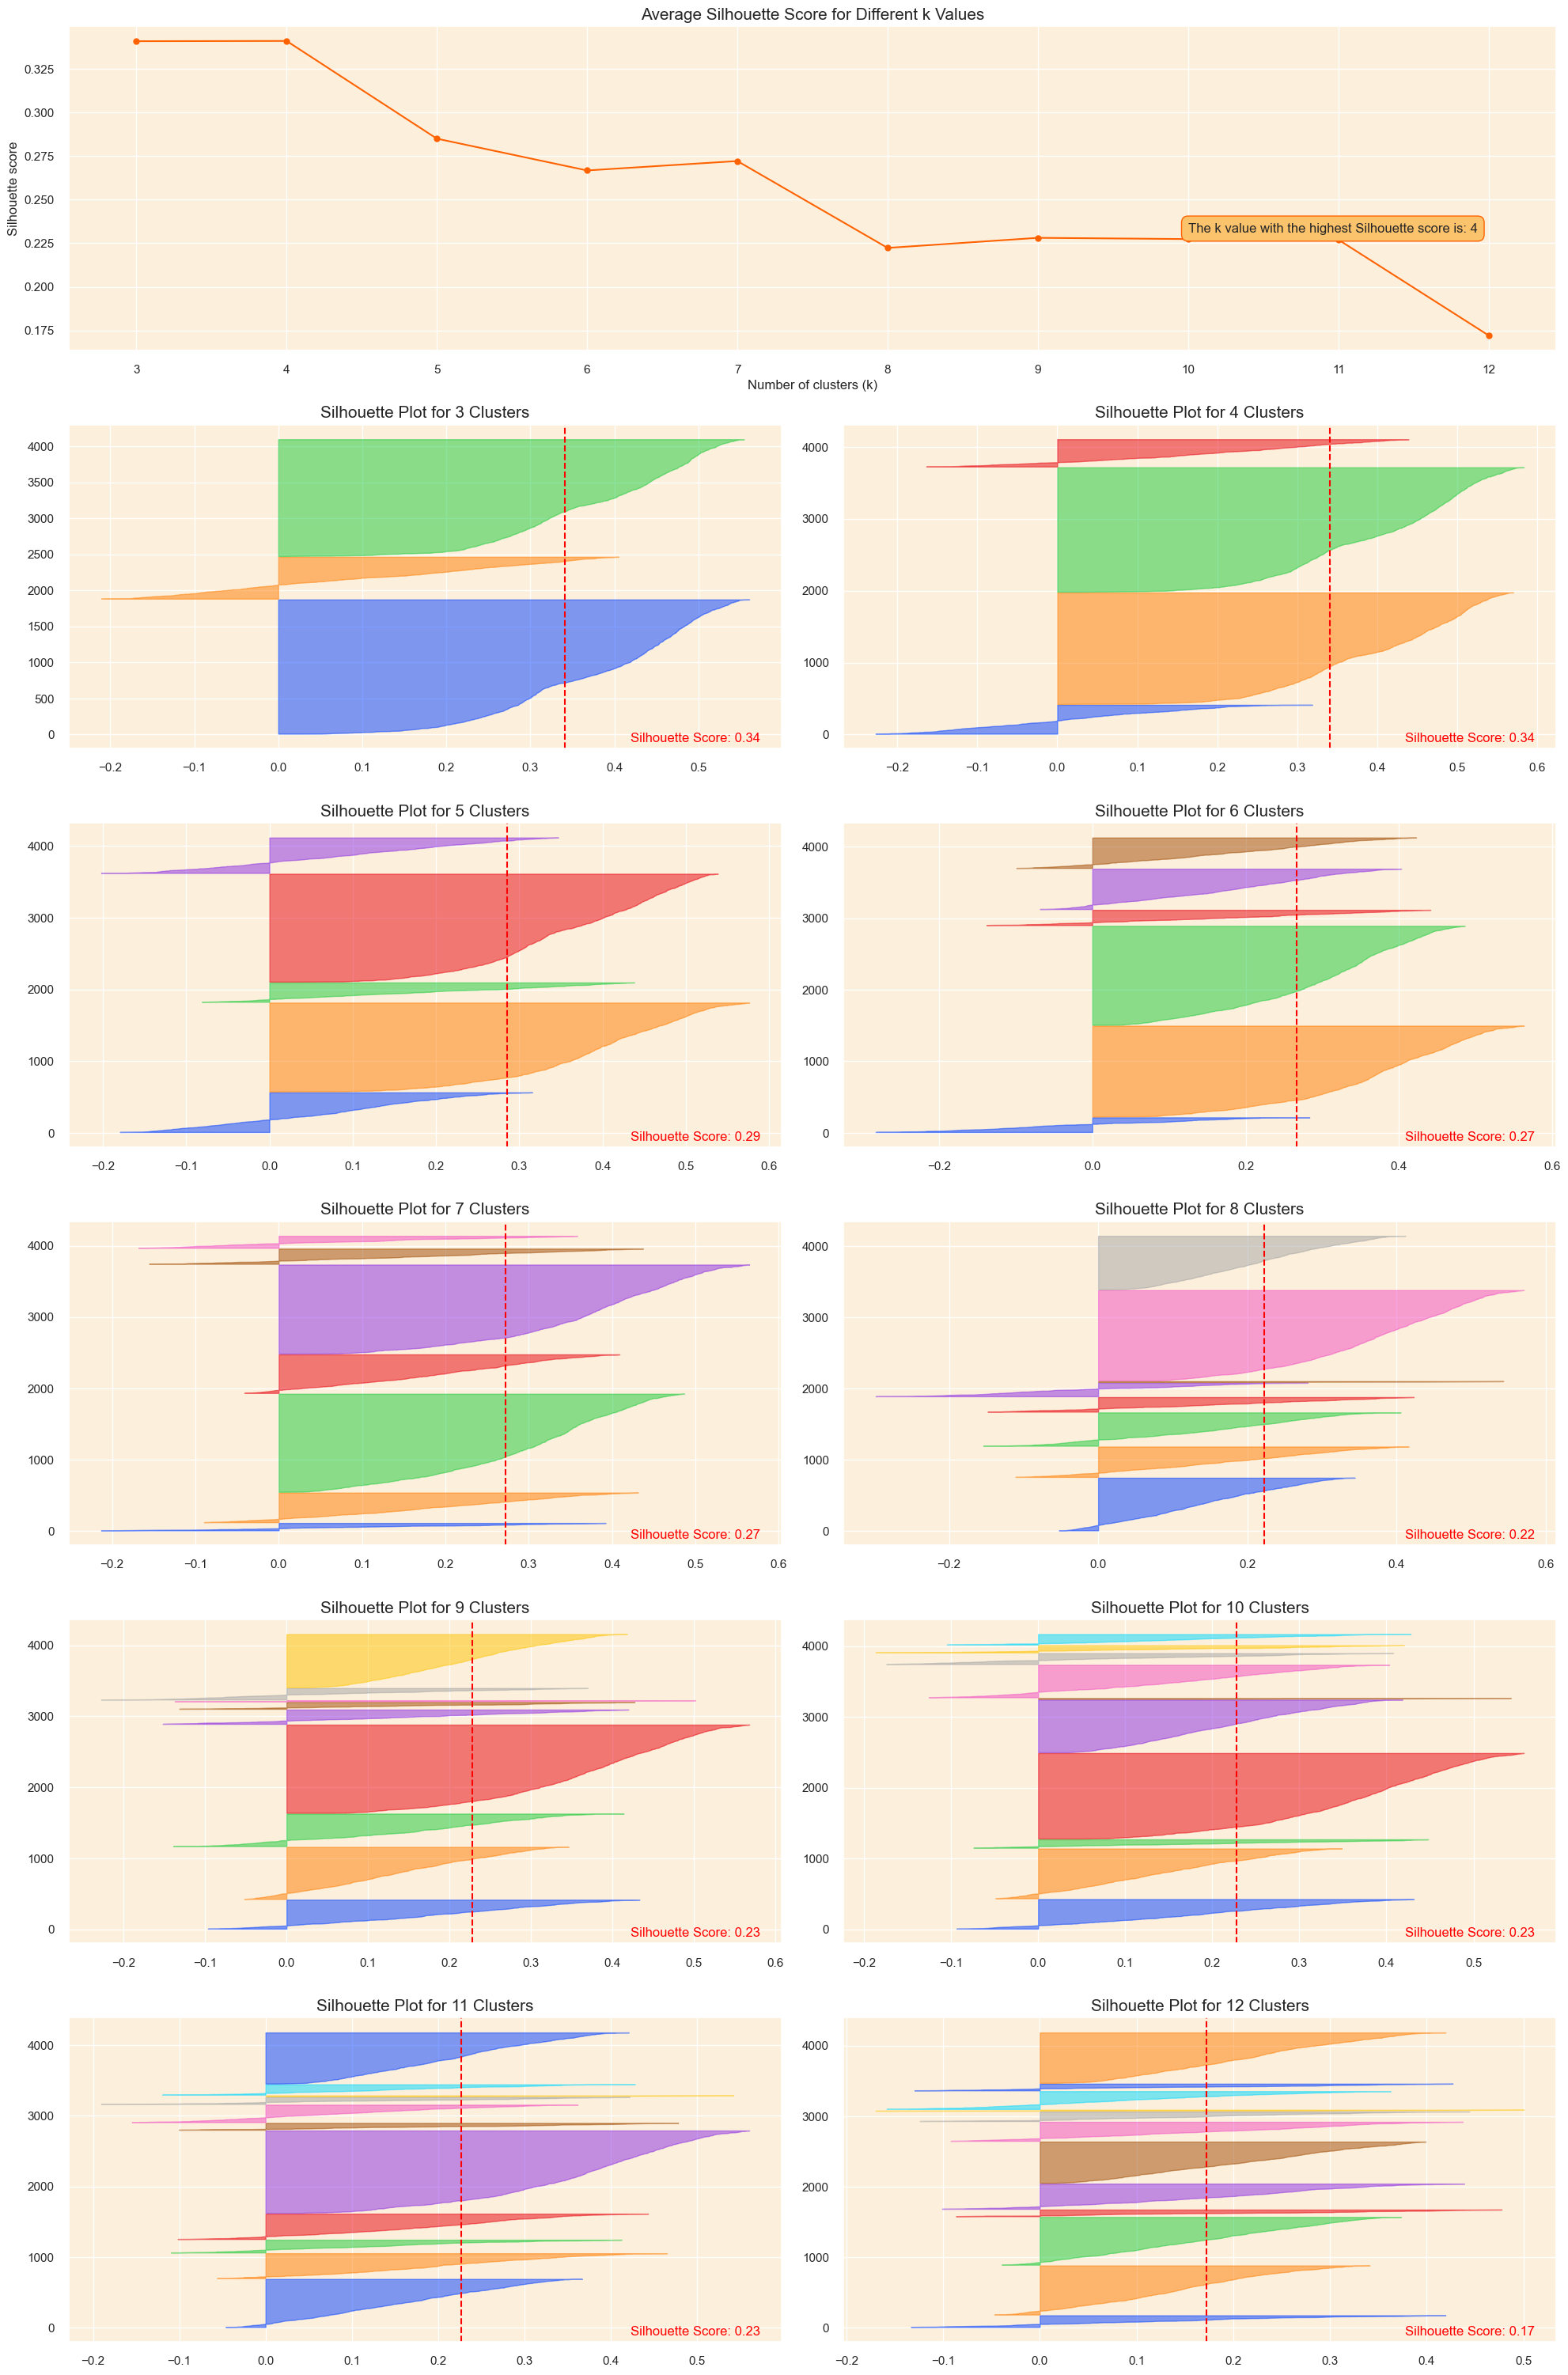

In [82]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Clustering Model - K-means</span></b>


In [83]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [84]:
# Display the first few rows of the original dataframe
customer_data_cleaned[customer_data_cleaned["cluster"]==0]

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,259266.0,325,2,0,0.0,0.0,1,0.0,6,6,1,1,0.5,0.0,0.0,0.0,0
1,259287.0,2,6,6417,14928.18,2488.03,85,2.1,5,8,0,0,0.0,2488.03,1537.619795,109.482857,0
4,259392.0,36,11,1410,6406.32,582.392727,57,2.765957,6,10,0,3,0.272727,1281.264,877.069839,165.024,0
7,259455.0,214,1,720,1905.78,1905.78,11,0.0,5,9,0,0,0.0,1905.78,0.0,0.0,0
8,259518.0,1,2,744,4840.44,2420.22,10,8.277778,6,6,0,0,0.0,2420.22,580.987216,821.64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,383565.0,72,2,927,3198.18,1599.09,42,2.0,5,11,1,0,0.0,1599.09,514.420183,-727.5,0
4056,383670.0,38,3,291,990.54,330.18,11,19.0,6,8,1,1,0.166667,330.18,461.119823,122.76,0
4062,383838.0,73,1,198,721.2,721.2,9,0.0,6,7,1,0,0.0,721.2,0.0,0.0,0
4063,383880.0,277,1,135,748.65,748.65,10,0.0,5,5,1,0,0.0,748.65,0.0,0.0,0


# <b><span style='color:#fcc36d'></span><span style='color:#007bff'>  Cluster Distribution Visualization</span></b>


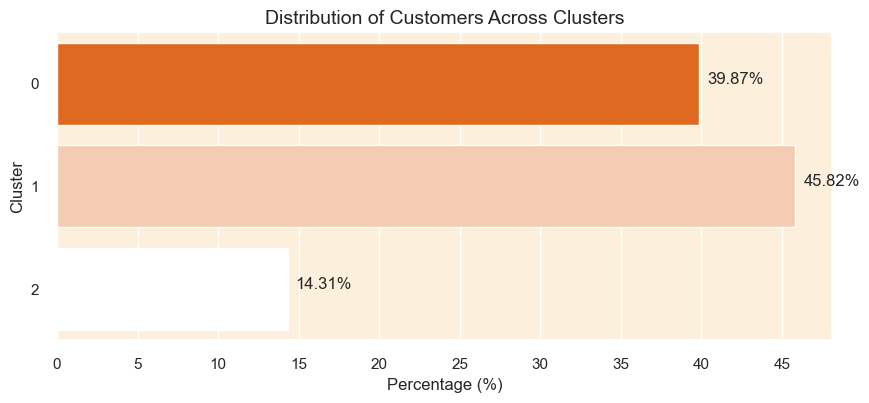

In [85]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# <b><span style='color:#fcc36d'></span><span style='color:#007bff'> Evaluation Metrics</span></b>


In [86]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4068         |
|    Silhouette Score     | 0.34103948552666496 |
| Calinski Harabasz Score | 1667.2464696719921  |
|  Davies Bouldin Score   | 1.1589237423550183  |
+-------------------------+---------------------+


# Cluster Analysis and Profiling


# Recommendation System


<div style="border-radius:10px; padding: 15px; background-color: ; font-size:120%; text-align:left">

In the final phase of this project, I am set to develop a recommendation system to enhance the online shopping experience. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. Earlier in the project, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called `outliers_data`.

Now, focusing on the core 95% of the customer group, I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting __the top three products__ popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. For the outlier group, a basic approach could be to recommend random products, as a starting point to engage them.

In [87]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])

top_products_per_cluster = best_selling_products.groupby('cluster').head(10)



In [88]:
top_products_per_cluster

,cluster,StockCode,Description,Quantity
3009,0,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,18402
2791,0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,15588
3175,0,1787583.0,WHITE HANGING HEART T-LIGHT HOLDER,14667
3162,0,1787079.0,JUMBO BAG RED RETROSPOT,13236
391,0,445452.0,PACK OF 72 RETROSPOT CAKE CASES,12249
2638,0,1302378.0,SOMBRERO,11067
28,0,336294.0,SMALL CHINESE STYLE SCISSOR,10860
66,0,357063.0,BROCADE RING PURSE,10377
1322,0,472332.0,MINI PAINT SET VINTAGE,9612
31,0,336945.0,POPART WOODEN PENCILS ASST,9000


## 
####  The loop goes through each cluster and for each customer in that cluster:
#### Checks what products the customer already bought.
#### Finds top-selling products that the customer hasn't bought yet.
#### Picks the top 3 of these products for recommendation.

In [89]:
# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [90]:
customer_purchases

,CustomerID,cluster,StockCode,Quantity
0,259266.0,0,486486.0,0
1,259287.0,0,336168.0,72
2,259287.0,0,357441.0,108
3,259287.0,0,433965.0,18
4,259287.0,0,435099.0,120
...,...,...,...,...
218495,384027.0,1,1776264.0,18
218496,384027.0,1,1783320.0,12
218497,384027.0,1,1785819.0,648
218498,384027.0,1,1785840.0,144


In [91]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
335748.0,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787583.0,WHITE HANGING HEART T-LIGHT HOLDER
335496.0,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787583.0,WHITE HANGING HEART T-LIGHT HOLDER
357042.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,378147.0,ESSENTIAL BALM 3.5G TIN IN ENVELOPE
356160.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,378147.0,ESSENTIAL BALM 3.5G TIN IN ENVELOPE
315567.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1782459.0,ASSORTED COLOUR BIRD ORNAMENT,378147.0,ESSENTIAL BALM 3.5G TIN IN ENVELOPE
304584.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787079.0,JUMBO BAG RED RETROSPOT,445452.0,PACK OF 72 RETROSPOT CAKE CASES
304542.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787079.0,JUMBO BAG RED RETROSPOT,1775928.0,GIRLS ALPHABET IRON ON PATCHES
371322.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787079.0,JUMBO BAG RED RETROSPOT,445452.0,PACK OF 72 RETROSPOT CAKE CASES
372330.0,1765617.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,1787079.0,JUMBO BAG RED RETROSPOT,1782459.0,ASSORTED COLOUR BIRD ORNAMENT


In [92]:
customer_data_cleaned

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,259266.0,325,2,0,0.0,0.0,1,0.0,6,6,1,1,0.5,0.0,0.0,0.0,0
1,259287.0,2,6,6417,14928.18,2488.03,85,2.1,5,8,0,0,0.0,2488.03,1537.619795,109.482857,0
2,259308.0,75,4,7023,7481.52,1870.38,21,9.433333,1,15,0,0,0.0,1870.38,1249.579637,-671.256,1
3,259350.0,310,1,591,1387.2,1387.2,16,0.0,0,12,0,0,0.0,1387.2,0.0,0.0,1
4,259392.0,36,11,1410,6406.32,582.392727,57,2.765957,6,10,0,3,0.272727,1281.264,877.069839,165.024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,383880.0,277,1,135,748.65,748.65,10,0.0,5,5,1,0,0.0,748.65,0.0,0.0,0
4064,383901.0,180,1,162,334.8,334.8,7,0.0,4,6,1,0,0.0,334.8,0.0,0.0,0
4065,383922.0,7,3,294,733.05,244.35,12,9.916667,2,9,1,1,0.25,366.525,62.175899,-87.93,1
4066,383943.0,3,16,4071,8490.27,530.641875,258,0.463889,1,10,1,0,0.0,943.363333,851.683174,217.7095,2


### word2vec base on Description

In [93]:
# from gensim.models import Word2Vec

# # Prepare sequences: Treat each customer's purchases as a "sentence" of products
# purchase_sequences = merged_data.groupby('CustomerID')['Description'].apply(list).tolist()

# # Train a Word2Vec model on these sequences
# model_w2v = Word2Vec(sentences=purchase_sequences, vector_size=100, window=5, min_count=1, workers=4)

# # After training, you can get vectors for each item and use these vectors to find similar items
# item_vector = model_w2v.wv["POPPY'S PLAYHOUSE LIVINGROOM "]  # Example StockCode

# # Find similar items
# similar_items = model_w2v.wv.most_similar("POPPY'S PLAYHOUSE LIVINGROOM ", topn=5)


In [94]:
# similar_items

## Final Implementation: Gradio User Interface for the Recommendation System

In [95]:
# pip install tensorflow transformers

In [96]:
# pip install tensorflow

In [97]:
! python3 --version

Python 3.11.4


In [98]:
! PIP --version


pip 24.0 from /Users/osamah/anaconda3/lib/python3.11/site-packages/pip (python 3.11)


In [99]:
# pip install --upgrade gradio

In [100]:
# pip install tensorflow

In [101]:
# pip install gradio

In [102]:
import gradio as gr

def get_recommendations(customer_id):
    # Convert input to float to match your DataFrame's type
    customer_id = float(customer_id)
    # Filter recommendations for this specific customer
    recommendations = customer_data_with_recommendations[
        customer_data_with_recommendations['CustomerID'] == customer_id]
    if not recommendations.empty:
        # Returning the descriptions of the recommended products
        return (recommendations.iloc[0]['Rec1_Description'],
                recommendations.iloc[0]['Rec2_Description'],
                recommendations.iloc[0]['Rec3_Description'])
    return ("No recommendations available", "No recommendations available", "No recommendations available")

# Create Gradio interface
iface = gr.Interface(fn=get_recommendations,
                     inputs=gr.Textbox(label="Enter Customer ID"),
                     outputs=[gr.Textbox(label="Recommendation 1"),
                              gr.Textbox(label="Recommendation 2"),
                              gr.Textbox(label="Recommendation 3")],
                     title="Product Recommendation System",
                     description="Type in a Customer ID to see the top 3 product recommendations.")

# Launch the app
iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


<h2 align="left"><font color='#ff6200'>Best Regards!</font></h2>